# Flare Isolation (CD55)
The goal of this notebook is to isolate the flares from stars' background behavior for anaylsis (energy, shape without other contributions)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy import constants as const

from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.integrate import simps

import lightkurve as lk

import altaipony as ap
from altaipony.flarelc import FlareLightCurve

%matplotlib inline

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Grab identifying data of coinciding flares from `..\data\spt_tess_candidates_23_jun25.pkl`.

In [2]:
coinciding_flares_df = pd.read_pickle('..\..\data\spt_tess_candidates_23_jun25.pkl')
print(coinciding_flares_df.columns)
coinciding_flares_df

Index(['index', 'peak_obsid', 'DR3_source_id', 'ra', 'dec', 'start_time',
       'end_time', 'mjd', 'sectors', 'TIC'],
      dtype='object')


<>:1: DeprecationWarning: invalid escape sequence \.
<>:1: DeprecationWarning: invalid escape sequence \.
C:\Users\vishn\AppData\Local\Temp\ipykernel_4396\1781125562.py:1: DeprecationWarning: invalid escape sequence \.
  coinciding_flares_df = pd.read_pickle('..\..\data\spt_tess_candidates_23_jun25.pkl')


,index,peak_obsid,DR3_source_id,ra,dec,start_time,end_time,mjd,sectors,TIC
0,12,205545046,6463748969563201408,319.964017,-53.449742,2023-07-07 23:50:47,2023-07-08 01:58:35,60132.993600,[67],TIC79394645
1,13,206191850,6388014157668558080,352.241030,-68.043088,2023-07-15 11:30:51,2023-07-15 13:38:39,60140.479757,[67],TIC229807000
2,14,206333946,6463546350186454144,320.183645,-54.633106,2023-07-17 02:59:07,2023-07-17 05:06:55,60142.124387,[67],TIC219317273
3,17,210122640,4904142818493218304,13.575856,-59.422393,2023-08-29 23:24:01,2023-08-30 01:31:49,60185.975012,[69],None


Pull highest cadence TESS lightcurve with lightkurve

In [82]:
flare_star = coinciding_flares_df.iloc[2]
obj = lk.search_lightcurve(flare_star['TIC'], mission= 'TESS', sector= flare_star["sectors"][0], exptime= 'fast')
if len(obj) == 0: obj = lk.search_lightcurve(flare_star['TIC'], mission= 'TESS', sector= flare_star["sectors"][0], exptime= 'short')
if len(obj) == 0: obj = lk.search_lightcurve(flare_star['TIC'], mission= 'TESS', sector= flare_star["sectors"][0])
flare_lc = obj[0].download()
(flare_lc['time'][1]- flare_lc['time'][0]).value * 24 * 3600 * u.s

2% (229/11719) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
2% (229/11719) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


<Quantity 200.00783391 s>

In [13]:
# print(type(flare_lc), type(flare_lc.flux), type(flare_lc.sap_flux), type(flare_lc.pdcsap_flux))
# print(flare_lc.flux.shape, flare_lc.flux.unit, flare_lc.sap_flux.unit, flare_lc.pdcsap_flux.unit)

`lightkurve.lightcurve` objects store flux/sap_flux/pdcsap_flux as `<class 'astropy.utils.masked.core.MaskedQuantity'>`, which breaks as lightkurves own implementation of `lightcurve.normalize()` & `lightcurve.flatten()`. We will get around this by re-assigning with the unmasked values (which should be standard `numpy.ndarray`).

In [14]:
flare_lc.flux = flare_lc.flux.unmasked
flare_lc.flux_err = flare_lc.flux_err.unmasked
flare_lc.sap_flux = flare_lc.sap_flux.unmasked
flare_lc.sap_flux_err = flare_lc.sap_flux_err.unmasked
flare_lc.pdcsap_flux = flare_lc.pdcsap_flux.unmasked
flare_lc.pdcsap_flux_err = flare_lc.pdcsap_flux_err.unmasked
flare_lc = flare_lc.remove_nans()

PDCSAP processing sometimes doesn't know how to account for the flare resulting in significant data artifacts. So we will prefer to use SAP and do any detrending ourselves

5085 60142.12513674303 3142.6259374803617
Dominant Frequency: 0.41450 1 / d <-> Dominant Period: 2.41254 d -> Max Power: 2791.31035 electron / s


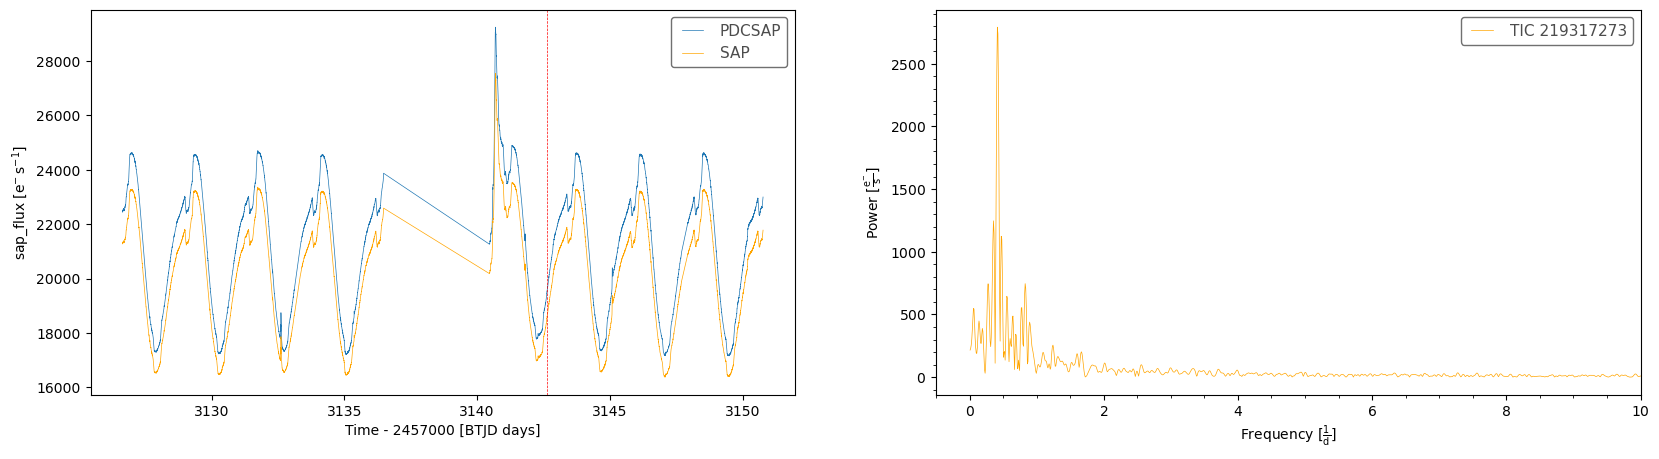

In [15]:
flare_lc = flare_lc.remove_nans()
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
flare_lc.plot(ax= ax1, column= 'pdcsap_flux', label="PDCSAP")
flare_lc.plot(ax=ax1, column= 'sap_flux', label="SAP", color= 'orange')
flare_lc = flare_lc.select_flux('sap_flux')

time_tdb = Time(flare_lc.time.value, format= flare_lc.time.format, scale= flare_lc.time.scale)
time_utc = time_tdb.utc.mjd
flare_start_idx = np.abs(time_utc-flare_star['mjd']).argmin()
print(flare_start_idx, time_utc[flare_start_idx], flare_lc.time.value[flare_start_idx])
ax1.axvline(flare_lc.time.value[flare_start_idx], ls= '--', lw= 0.5, c= 'r')

p = flare_lc.to_periodogram('ls')
p.plot(ax = ax2, color= 'orange')
ax2.set_xlim(-1/2,10)
# ax2.plot()
print(f'Dominant Frequency: {p.frequency_at_max_power:.5f} <-> Dominant Period: {p.period_at_max_power:.5f} -> Max Power: {p.max_power:.5f}')


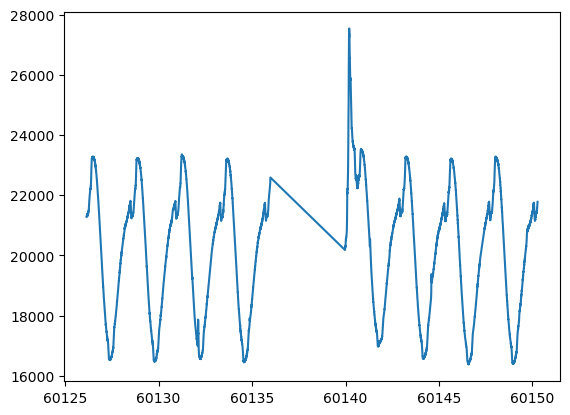

In [20]:
flare_lc.time = time_utc

plt.plot(flare_lc.time.value, flare_lc.flux.value)

# Removing Quiescent Behaviors

As CD55's lc has a very clear periodic behavior we will first remove the most dominant frequencies with a periodogram (search literature for methods to standardize how we remove strong frequencies)

To start I manually create flare mask

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

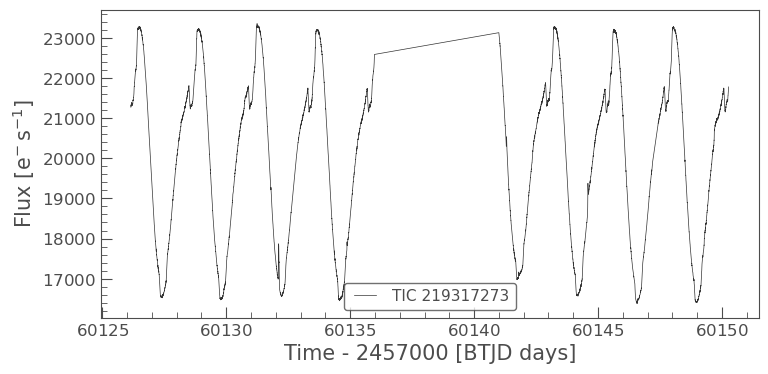

In [21]:
og_flare_lc = flare_lc.copy()
og_flare_lc = og_flare_lc.remove_nans()

# We define as a lambda function as we will continue to cut the time array throughout this process
flare_mask_maker = lambda times: (times.value > 60139.5) & (times.value < 60141)

flare_mask = flare_mask_maker(og_flare_lc.time)
og_flareless_lc = og_flare_lc.copy()[~flare_mask]

og_flareless_lc.plot()

The goal is to remove as much of the underlying periodic behavior without introducing artifacts.
We mask out the flare to maximize the periodigrams ability to pick up the underlying behavior.

For Matt I find `iterations=2` to be best.

Dominant Frequency: 0.41450 1 / d <-> Dominant Period: 2.41254 d -> Max Power: 2732.86290 electron / s


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

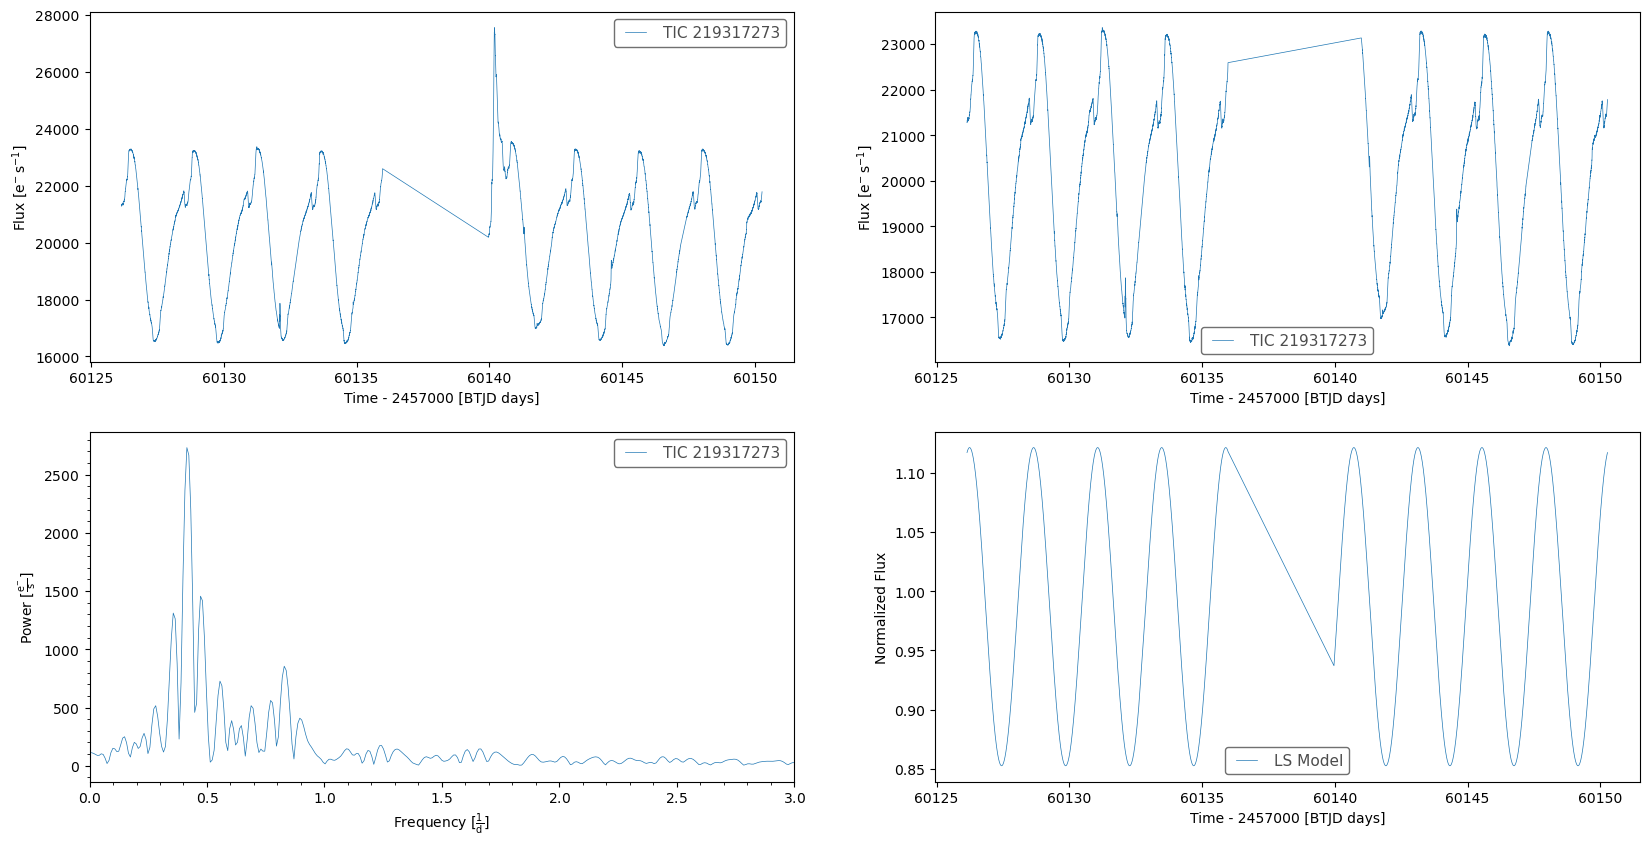

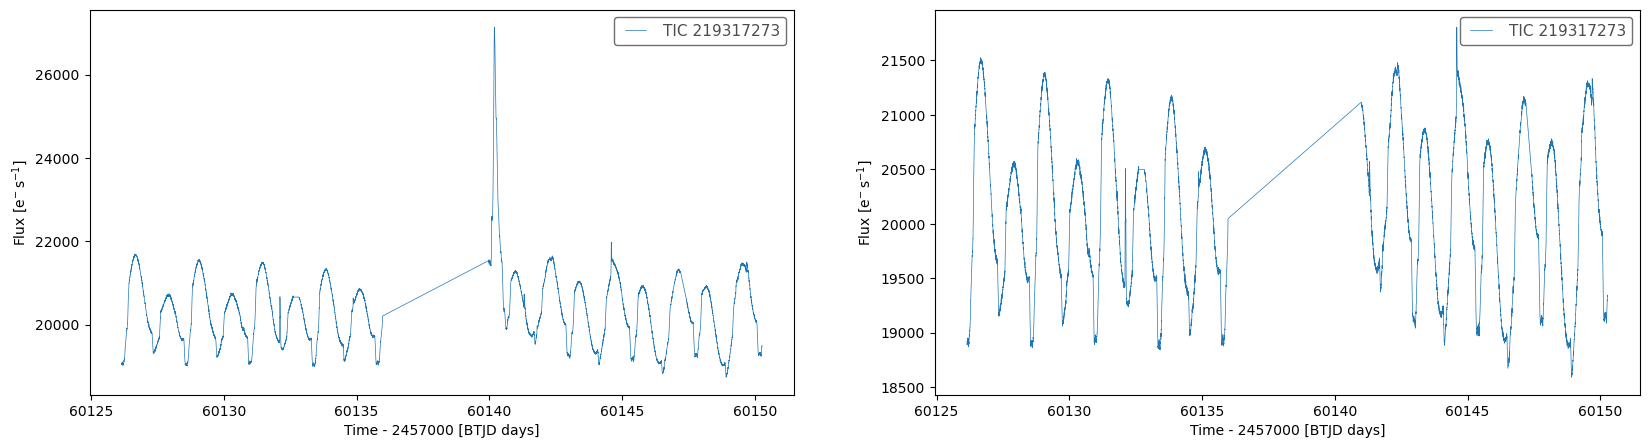

In [27]:
flare_lc = og_flare_lc.copy()
flareless_lc = og_flareless_lc.copy()

iterations = 1
for i in range(iterations):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 10))
    flare_lc.plot(ax= ax1)
    flareless_lc.plot(ax= ax2)

    p = flareless_lc.to_periodogram('ls')
    p.plot(ax= ax3)
    ax3.set_xlim(0,3)
    print(f'Dominant Frequency: {p.frequency_at_max_power:.5f} <-> Dominant Period: {p.period_at_max_power:.5f} -> Max Power: {p.max_power:.5f}')

    model = p.model(flare_lc.time, p.frequency_at_max_power)
    model_less = p.model(flareless_lc.time, p.frequency_at_max_power)
    model.plot(ax= ax4)

    flare_lc.flux = flare_lc.flux / model['flux']
    flareless_lc.flux = flareless_lc.flux / model_less['flux']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
flare_lc.plot(ax= ax1)
flareless_lc.plot(ax= ax2)
# ax1.set_xlim(59065, 59072)

Unfortunately the above code starts introducing artifacts for this flare if we do more than 1 iteration.

So, the next step is to use AltaiPony to remove remaining long term trends.

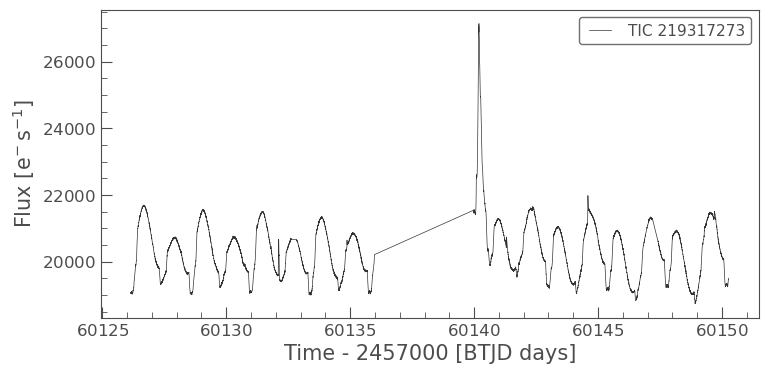

In [38]:
flc = FlareLightCurve(flare_lc)
ax = flc.plot()

window length: 43.0
window length: 43.0
window length: 43.0
window length: 43.0


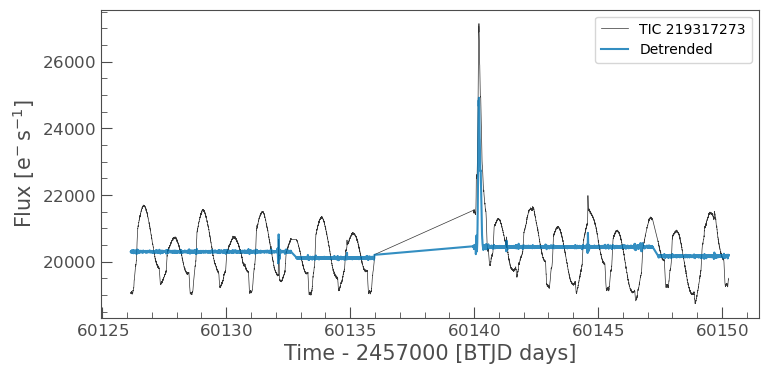

[(0, 2795), (2795, 4154), (4154, 7094), (7094, 8325)]

In [45]:
flc = flc.detrend(mode= 'savgol', printwl= True)
ax = flc.plot()
ax.plot(flc.time.value, flc.detrended_flux.value, label='Detrended', alpha= 0.8)
ax.legend()
# ax.set_ylim(700, 800)
plt.show()
flc.gaps

In [46]:
flc = flc.find_flares(N1= 5)
flc.flares

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points
0,2576,2583,823024,823031,60132.111051,60132.127255,26.193332,0.311404,0.025492,0.016204,8325.0
1,4204,4211,826469,826476,60140.085748,60140.101952,15.200640,0.326420,0.016569,0.016204,8325.0
2,4223,4317,826488,826582,60140.129730,60140.347328,1957.389256,1.168463,0.218947,0.217597,8325.0
3,4376,4379,826641,826644,60140.483905,60140.490849,2.338565,0.235120,0.004155,0.006945,8325.0
4,4733,4739,826998,827004,60141.310309,60141.324198,6.906949,0.301359,0.009024,0.013889,8325.0
5,4944,4947,827209,827212,60141.798743,60141.805688,2.591629,0.207186,0.004671,0.006945,8325.0
6,6150,6157,828415,828422,60144.590440,60144.606644,17.419600,0.308033,0.020634,0.016204,8325.0
7,6898,6902,829230,829236,60146.477025,60146.490914,4.722306,0.345126,0.004586,0.013889,8325.0
8,6970,6975,829367,829373,60146.794156,60146.808045,4.810425,0.303480,0.005636,0.013889,8325.0


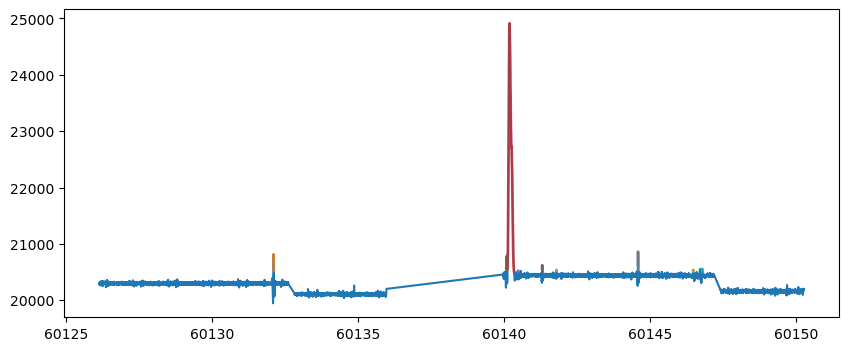

In [56]:
f, ax = plt.subplots(1,1, figsize= (10,4))
ax.plot(flc.time.value, flc.detrended_flux.value)
for flare in flc.flares.iterrows():
    flare = flare[1]
    istart = flare['istart']
    istop = flare['istop']
    ax.plot(flc.time.value[istart:istop], flc.detrended_flux.value[istart:istop], alpha= 0.75, linewidth= 2)
# ax.set_ylim(20000, 20750)
# ax.set_xlim(60139.5, 60145)

We isolate to the relevant TESS orbit as there may still be some systematics unique to each one (i.e. baseline may shift even with detrending)
We then calculate detrended quiscent flux again using the flare mask

In this case we want the lc before the gap.

Quiescent Flux: 20440.384 +/- 28.314


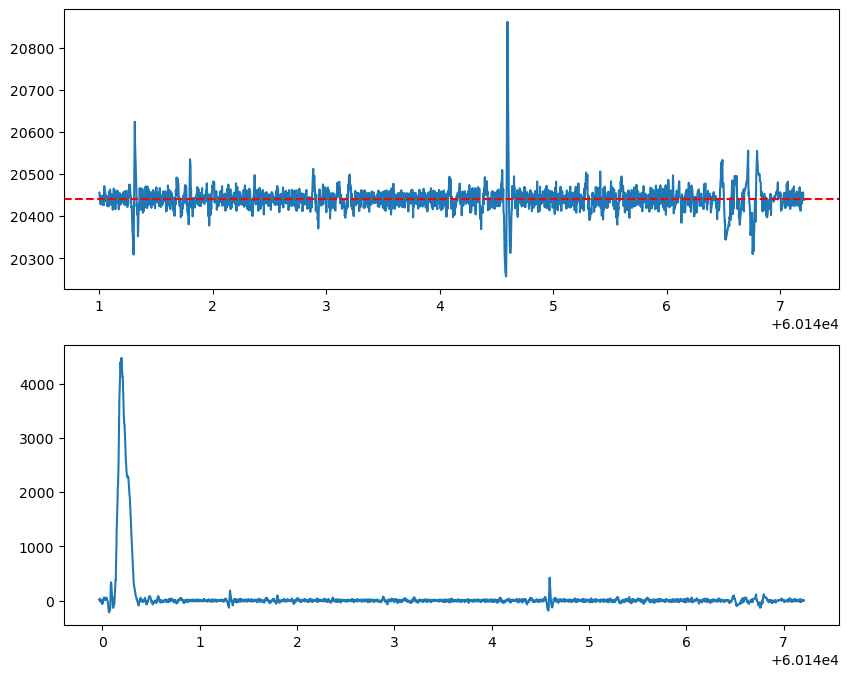

In [55]:
flare_sig = {
    "time": flc.time[flc.gaps[2][0]:flc.gaps[2][1]].copy(),
    "detrended_flux": flc.detrended_flux[flc.gaps[2][0]:flc.gaps[2][1]].copy(),
    "detrended_flux_err": flc.detrended_flux_err[flc.gaps[2][0]:flc.gaps[2][1]].copy(),
    "quies_subtr": flc.detrended_flux[flc.gaps[2][0]:flc.gaps[2][1]].copy(),
    "quies_subtr_err": flc.detrended_flux_err[flc.gaps[2][0]:flc.gaps[2][1]].copy(),
}

flares_mask = flare_mask_maker(flare_sig['time'])

f, (ax1,ax2) = plt.subplots(2,1, figsize= (10,8))
ax1.plot(flare_sig['time'][~flares_mask].value, flare_sig['detrended_flux'][~flares_mask].value)

quies = np.mean(flare_sig['detrended_flux'][~flares_mask])
quies_err = np.std(flare_sig['detrended_flux'][~flares_mask])
print(f'Quiescent Flux: {quies:.3f} +/- {quies_err:.3f}')
ax1.axhline(quies, color='red', linestyle='--', label='Quiescent Flux')
flare_sig['quies_subtr'] -= quies
flare_sig['quies_subtr_err'] += quies_err #? Is this proper error propagation?
ax2.plot(flare_sig['time'].value, flare_sig['quies_subtr'].value)

# Fit Flare Shape

Now that we have relative flux, we can move to fitting the flare. We will do a rough clip around the flare

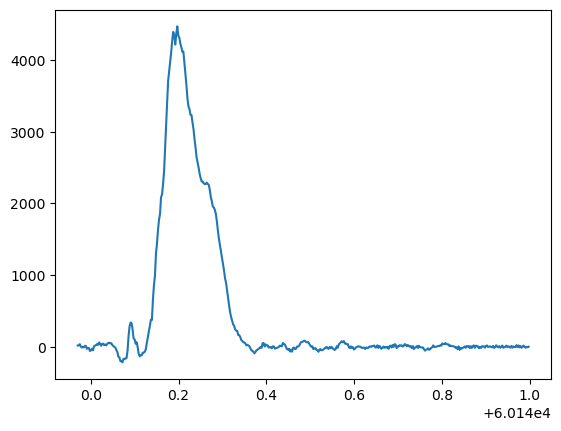

In [57]:
spt_flare_mask = (flare_sig['time'].value > 60139) & (flare_sig['time'].value < 60141)

SPT_flare = flare_sig.copy()
SPT_flare['time'] = SPT_flare['time'][spt_flare_mask]
SPT_flare['detrended_flux'] = SPT_flare['detrended_flux'][spt_flare_mask]
SPT_flare['detrended_flux_err'] = SPT_flare['detrended_flux_err'][spt_flare_mask]
SPT_flare['quies_subtr'] = SPT_flare['quies_subtr'][spt_flare_mask]
SPT_flare['quies_subtr_err'] = SPT_flare['quies_subtr_err'][spt_flare_mask]

plt.plot(SPT_flare['time'].value, SPT_flare['quies_subtr'].value, label='Quiescent Subtracted')

Next we want to decide what part of this region we are going to fit and integrate over to compute the flare energy.

I decide to do this by computing a moving average <span style="color:red;">(adjust window size as needed)</span> and setting the bounds where it approaches  $c\cdot noise$. Noise is defined by the std of our quiescent signal and we adjust c as needed to capture a the full flare dynamics. <span style="color:red;">(Be careful of making it to small as it can give wrong bounds)</span>

Flare region: start at time 60140.12741561178, end at time 60140.345012850295


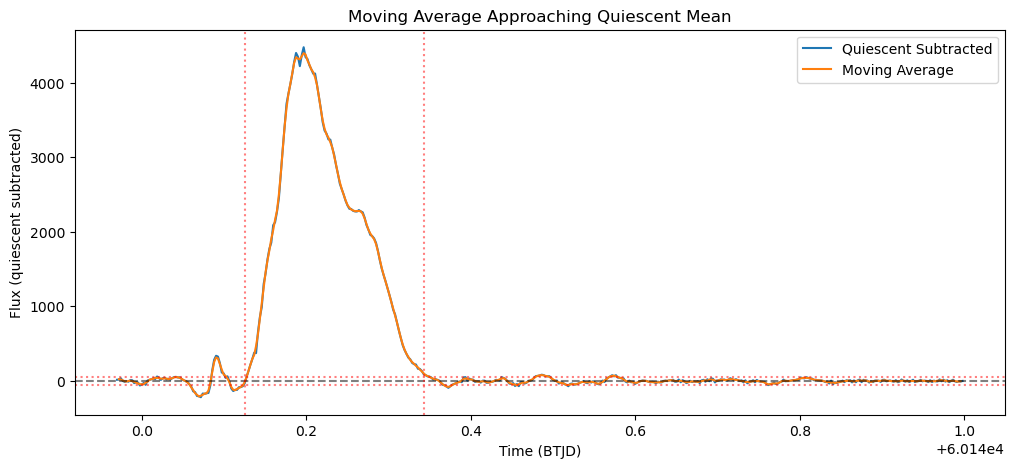

In [60]:
window_size = 3  # Adjust window size as needed
moving_avg = np.convolve(SPT_flare['quies_subtr'], np.ones(window_size)/window_size, mode='valid')

# Find the flare peak index (maximum absolute deviation from quiescent)
peak_idx = np.argmax(np.abs(SPT_flare['quies_subtr'].value))
# Search for threshold crossings starting from the peak
search_indices = np.arange(peak_idx, len(moving_avg))

# Find where moving average drops below threshold after the peak (end of flare)
end_candidates = search_indices[np.where(np.abs(moving_avg[search_indices]) < 3 * quies_err)[0]]
if len(end_candidates) > 0:
    last_idx = end_candidates[0]
else:
    last_idx = len(moving_avg) - 1

# Find where moving average rises above threshold before the peak (start of flare)
search_indices_rev = np.arange(peak_idx, -1, -1)
start_candidates = search_indices_rev[np.where(np.abs(moving_avg[search_indices_rev]) < 3 * quies_err)[0]]
if len(start_candidates) > 0:
    first_idx = start_candidates[0]
else:
    first_idx = 0

print(f"Flare region: start at time {SPT_flare['time'][first_idx + window_size//2]}, end at time {SPT_flare['time'][last_idx + window_size//2]}")


plt.figure(figsize=(12,5))
plt.plot(SPT_flare['time'].value, SPT_flare['quies_subtr'].value, label='Quiescent Subtracted')
plt.plot(SPT_flare['time'].value[window_size//2:-(window_size//2)], moving_avg, label='Moving Average')
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(2*quies_err, color='r', linestyle=':', alpha=0.5)
plt.axhline(-2*quies_err, color='r', linestyle=':', alpha=0.5)
plt.axvline(SPT_flare['time'][first_idx].value, color='r', linestyle=':', alpha=0.5)
plt.axvline(SPT_flare['time'][last_idx].value, color='r', linestyle=':', alpha=0.5)
plt.legend()
plt.xlabel('Time (BTJD)')
plt.ylabel('Flux (quiescent subtracted)')
plt.title('Moving Average Approaching Quiescent Mean')
plt.show()

Find fwhm to rescale time axis if needed

In [61]:
t = SPT_flare['time'].value
y = SPT_flare['quies_subtr'].value

# Assume t and y are arrays for time and normalized flux
half_max = 0.5 * np.max(y)

# Build interpolation function over time
interp_func = interp1d(t, y, kind='cubic', bounds_error=False)

# Create high-res time grid
t_fine = np.linspace(t[0], t[-1], 10000)
y_fine = interp_func(t_fine)

# Detect crossings on interpolated curve
above_half = y_fine >= half_max
rising_edges = np.where(np.diff(above_half.astype(int)) == 1)[0]
falling_edges = np.where(np.diff(above_half.astype(int)) == -1)[0]

if len(rising_edges) > 0 and len(falling_edges) > 0:
    t_rise = t_fine[rising_edges[0]]
    t_fall = t_fine[falling_edges[0]]
    fwhm = t_fall - t_rise

    print(f"Rise: {t_rise:.5f} d ({t_rise*24*60:.2f} min), "
          f"Fall: {t_fall:.5f} d ({t_fall*24*60:.2f} min), "
          f"FWHM: {fwhm:.5f} d ({fwhm*24*60:.2f} min)")
else:
    print("Could not determine FWHM on interpolated data.")


Rise: 60140.16397 d (86601836.12 min), Fall: 60140.26964 d (86601988.28 min), FWHM: 0.10567 d (152.16 min)


In [62]:
# Prepare data for fitting
t = SPT_flare['time'].value
y = SPT_flare['quies_subtr'].value
y_err = SPT_flare['quies_subtr_err'].value

t_peak = t[np.argmax(y)]
t_fwhm = (t - t_peak) / fwhm

scaling = np.max(SPT_flare['quies_subtr'].value)  # Scale factor for normalization
y_rel = SPT_flare['quies_subtr'].value / scaling  # Normalize the flux for fitting
y_err_rel = SPT_flare['quies_subtr_err'].value / scaling  # Normalize the flux for fitting

Text(0, 0.5, 'Relative Flux')

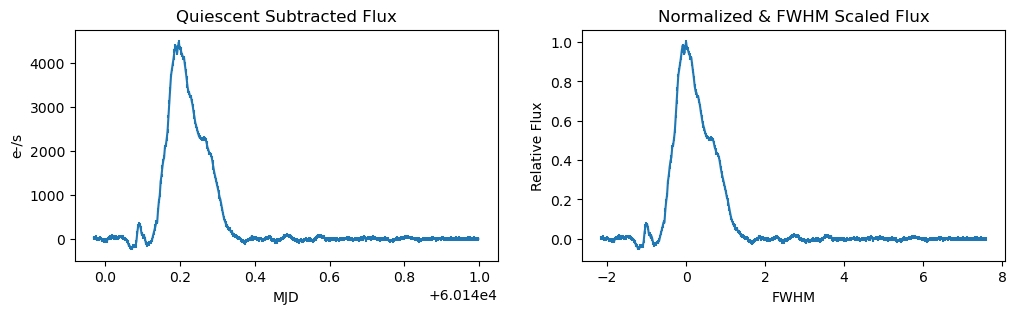

In [63]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.errorbar(t, y, y_err)
ax1.set_title('Quiescent Subtracted Flux')
ax1.set_xlabel('MJD')
ax1.set_ylabel('e-/s')
ax2.errorbar(t_fwhm, y_rel, yerr= y_err_rel)
ax2.set_title('Normalized & FWHM Scaled Flux')
ax2.set_xlabel('FWHM')
ax2.set_ylabel('Relative Flux')

In [64]:
# Define flare template functions
def gauss(t, t_peak, amp, sigma, offset):
    """Simple Gaussian function for flare fitting.
        Suggested by Howard and MacGregor (2023) for non_optical flares.
    """
    result = np.zeros_like(t)
    result = amp * np.exp(-0.5 * ((t - t_peak) / sigma) ** 2)
    return result + offset

def gauss_exp_decay(t, t_peak, amp, sigma, tau, offset):
    """No idea where I got this from :'|"""
    result = np.zeros_like(t)
    # Gaussian part for t <= t_peak
    mask_rise = t <= t_peak
    result[mask_rise] = amp * np.exp(-0.5 * ((t[mask_rise] - t_peak) / sigma) ** 2)
    # Exponential decay for t > t_peak
    mask_decay = t > t_peak
    result[mask_decay] = amp * np.exp(-0.5) * np.exp(-(t[mask_decay] - t_peak) / tau)
    return result + offset

def two_component_gaussian(t, t_peak, amp, sigma_rise, sigma_decay, offset):
    """Asymmetric Gaussian: different sigma for rise and decay.
        Used in Howard and MacGregor (2023) for flares with QPP substructure.
    """
    sigma = np.where(t < t_peak, sigma_rise, sigma_decay)
    return amp * np.exp(-0.5 * ((t - t_peak) / sigma) ** 2) + offset

def Davenport14_flare_template(t_fwhm, a, b, c, d, e, ea, f, fa):
    """Davenport et al. (2014) flare template function: 4th order polynomial rise with double exponential decay.
        Works for t_fwhm in days, normalized to FWHM and relative flux.
        The do have another possible parameterization of the decay, with the two decay terms "on" for distict regions of time,
        but this form seems better equipped for a variety of flares.
    """
    result = np.zeros_like(t_fwhm)
    mask_baseline = (t_fwhm < -1)
    result[mask_baseline] = 0
    # Gaussian part for t <= t_peak
    mask_rise = (t_fwhm <= 0) & (t_fwhm >= -1)
    result[mask_rise] = 1 + a * t_fwhm[mask_rise] + b * t_fwhm[mask_rise]**2 + c * t_fwhm[mask_rise]**3 + d * t_fwhm[mask_rise]**4
    # Exponential decay for t > t_peak
    mask_decay = t_fwhm > 0
    result[mask_decay] = e * np.exp(-ea * t_fwhm[mask_decay]) + f * np.exp(-fa * t_fwhm[mask_decay])
    return result

Fit overall flare signature and isolate QPP (if any)

C:\Users\vishn\AppData\Local\Temp\ipykernel_4396\2977608726.py:42: RuntimeWarning: overflow encountered in exp
  result[mask_decay] = e * np.exp(-ea * t_fwhm[mask_decay]) + f * np.exp(-fa * t_fwhm[mask_decay])


[ -0.18137131  -8.55579033 -12.29159007  -4.84570412   0.57275212
   1.64784603   0.57272041   1.64786713]


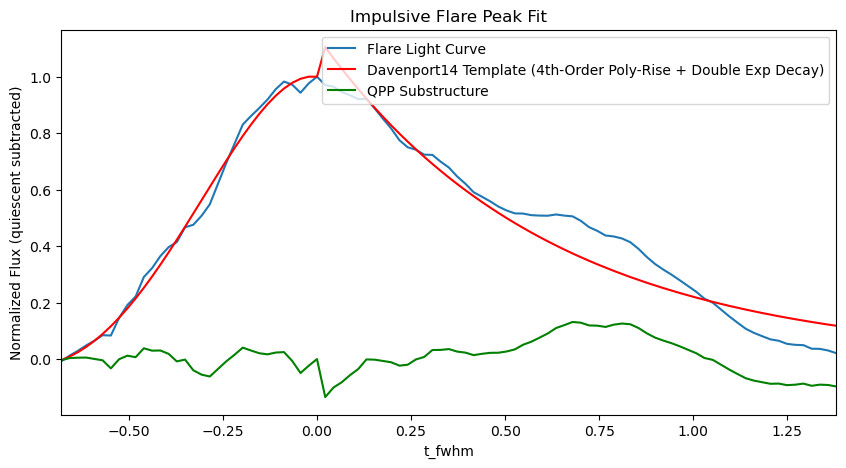

In [68]:
# Initial parameter guesses for primary flare peak
p0 = [None, None, None, None, None, None, None, None]  

popt, pcov = curve_fit(Davenport14_flare_template, t_fwhm, y_rel, maxfev=10000)
print(popt)

# Model fit for the full time range
model = Davenport14_flare_template(t_fwhm, *popt)

# Subtract model to isolate QPP substructure
qpp_substructure = y_rel - model

plt.figure(figsize=(10, 5))
plt.plot(t_fwhm, y_rel, label='Flare Light Curve')
plt.plot(t_fwhm, model, label='Davenport14 Template (4th-Order Poly-Rise + Double Exp Decay)', color='red')
plt.plot(t_fwhm, qpp_substructure, label='QPP Substructure', color='green')
plt.xlim(t_fwhm[first_idx], t_fwhm[last_idx])
plt.xlabel('t_fwhm')
plt.ylabel('Normalized Flux (quiescent subtracted)')
plt.legend()
plt.title('Impulsive Flare Peak Fit')
plt.show()

# Energy Calculation

Total flare fluence from fit (electrons): 9.50e+05 mJy s
Total flare energy from fit: 9.107041e+36 erg
Flare duration: 24.67 h


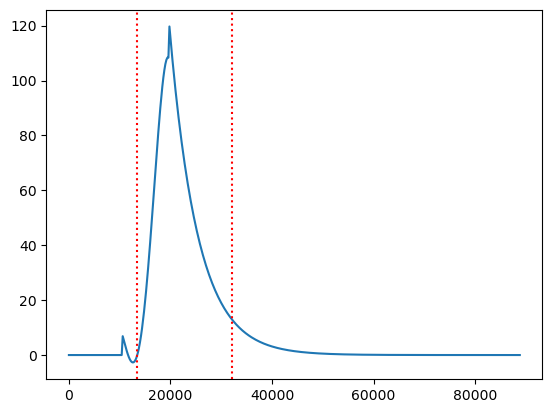

In [72]:
# model is normalized, scaling is the original flux peak
model_flux = model * scaling * 10**(-2/5*(20.44-16.4)) * u.mJy # in mJy
dt_sec = (t_fwhm - t_fwhm[0]) * fwhm * 3600*24 * u.s  # seconds since flare start
plt.plot(dt_sec, model_flux, label='Model Flux')
plt.axvline(dt_sec[first_idx].value, color='r', linestyle=':')
plt.axvline(dt_sec[last_idx].value, color='r', linestyle=':')

# Integrate model flux over time to get total fluence (electrons)
model_fluence = np.trapz(y= model_flux[first_idx:last_idx], x= dt_sec[first_idx:last_idx])
print(f"Total flare fluence from fit (electrons): {model_fluence:.2e}")

# Convert to energy (ergs)
d = (4.9967*u.mas).to(u.cm, equivalencies= u.parallax())
# d = 1/pi -> d_err = sigma_pi / pi^2 = sigma_pi/pi * d
d_err = (0.0147 * u.mas / (4.9967 * u.mas) * d)
model_energy = (model_fluence * (2e14 * u.Hz) * (4*np.pi*d**2)).to(u.erg)
print(f"Total flare energy from fit: {model_energy:3e}")
print(f"Flare duration: {dt_sec[-1].to(u.hr):.2f}")

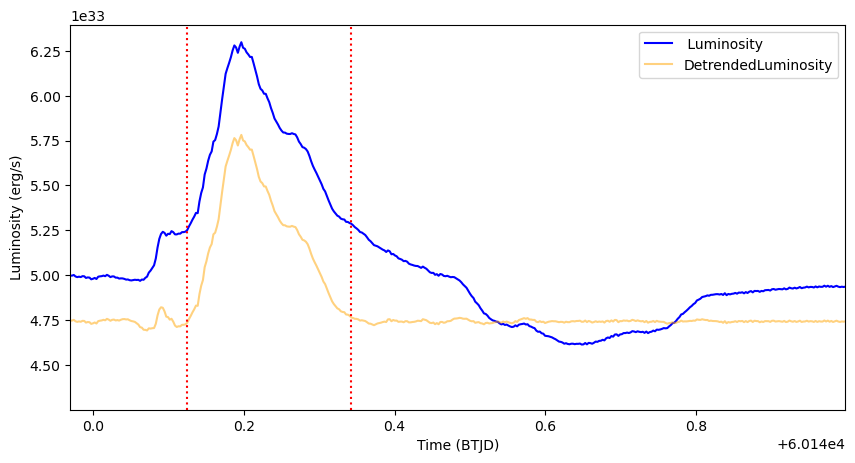

In [73]:
f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(flc['time'].value, flc['flux'].value * 10**(-2/5*(20.44-16.4)) * 1e-26 * 2e14 * (4*np.pi*d**2), label=' Luminosity', color= 'blue')
ax.plot(flc['time'].value, flc['detrended_flux'].value * 10**(-2/5*(20.44-16.4)) * 1e-26 * 2e14 * (4*np.pi*d**2), label='DetrendedLuminosity', color= 'orange', alpha=0.5)
ax.axvline(t[first_idx], color='r', linestyle=':')
ax.axvline(t[last_idx], color='r', linestyle=':')
ax.set_xlim(SPT_flare['time'].value[0], SPT_flare['time'].value[-1])
ax.set_xlabel('Time (BTJD)')
ax.set_ylabel('Luminosity (erg/s)')
ax.legend()

# Bolometric Energy Calculation <span style= 'color:red;'> (Test) </span>

Shibayama 2013 - https://ui.adsabs.harvard.edu/abs/2013ApJS..209....5S/abstract

In [75]:
from astropy.modeling.models import BlackBody

def BB_Lum(T, nus):
    bb_func = BlackBody(T)
    bb = bb_func(nus)

    spec_rad = np.trapz(x= nus, y= bb).to(u.erg / (u.cm**2 * u.s * u.sr))
    return spec_rad

def TESS_BB(T):
    nus = np.linspace((const.c / (1000*u.nm)), (const.c / (600*u.nm)), 1000).to(u.Hz)
    return BB_Lum(T, nus)

In [76]:
temp_time =  flare_sig['time'].copy()
temp_time =  (temp_time.value * u.day)

C_flare = flare_sig['detrended_flux'].copy() / quies

A_flare = C_flare * np.pi * (0.7928*const.R_sun.to(u.cm))**2 * TESS_BB(5149.6 *u.K).value / TESS_BB(10000*u.K).value

L_flare = (const.sigma_sb * (10000*u.K)**4 * A_flare).to(u.erg/u.s)
max(L_flare)

<Quantity 9.44321432e+32 erg / s>

<Quantity 1.57696e+37 erg>

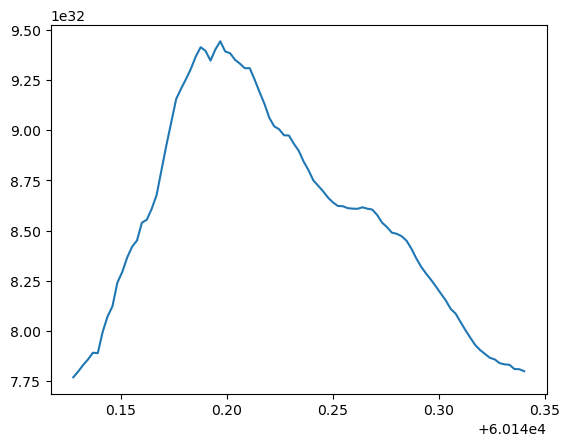

In [77]:
mask = (temp_time.value > t[first_idx]) & (temp_time.value < t[last_idx])

plt.plot(temp_time.value[mask], L_flare.value[mask])

np.trapz(x= temp_time[mask], y= L_flare[mask]).to(u.erg)